### Assessment 1 Part 2
#### Classification Model

* We investigate the development of several machine learning models aimed at classifying images as either containing a cat or a dog, while also assessing their accuracy.

In [2]:
# Basic Imports
import os
import random
import numpy as np
import pandas as pd
import pathlib

# Image Processing and Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
from PIL import Image

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
    BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import L2

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay
)

# For model visualization
from keras.utils import plot_model



In [3]:
# Import the data we were given
train_directory = pathlib.Path("dataset/train_data_small")
test_directory = pathlib.Path("dataset/test_data_small")


### Data split in two subdirectories for the classes : Cat and Dog for the train and test directories.

In [4]:
import os
import shutil
# move the data per class 
def organize_dataset(base_dir):
    # Paths
    cat_dir = os.path.join(base_dir, 'cat')
    dog_dir = os.path.join(base_dir, 'dog')

   
    os.makedirs(cat_dir, exist_ok=True)
    os.makedirs(dog_dir, exist_ok=True)


    for filename in os.listdir(base_dir):
        file_path = os.path.join(base_dir, filename)
        #skip directories
        if os.path.isdir(file_path): 
            continue
        #we access the images which start with cat or dog
        if filename.lower().startswith('cat'):
            shutil.move(file_path, os.path.join(cat_dir, filename))
        elif filename.lower().startswith('dog'):
            shutil.move(file_path, os.path.join(dog_dir, filename))

    print(f"Data successfully organized in '{base_dir}'.")


organize_dataset('dataset/train_data_small')


Data successfully organized in 'dataset/train_data_small'.


In [5]:
import os
import shutil
#We do the same for the other direcotry
def organize_dataset(base_dir):
   
    cat_dir = os.path.join(base_dir, 'cat')
    dog_dir = os.path.join(base_dir, 'dog')


    os.makedirs(cat_dir, exist_ok=True)
    os.makedirs(dog_dir, exist_ok=True)

    for filename in os.listdir(base_dir):
        file_path = os.path.join(base_dir, filename)
        if os.path.isdir(file_path):  
            continue
        if filename.lower().startswith('cat'):
            shutil.move(file_path, os.path.join(cat_dir, filename))
        elif filename.lower().startswith('dog'):
            shutil.move(file_path, os.path.join(dog_dir, filename))

    print(f"Data successfully organized in '{base_dir}'.")


organize_dataset('dataset/test_data_small')

Data successfully organized in 'dataset/test_data_small'.


### Check the first 10 pictures for the cats and dogs.

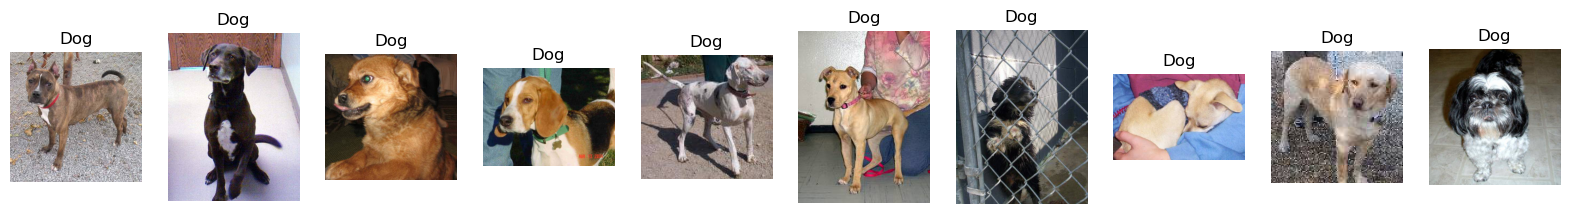

In [6]:
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Define the directory containing test data
test_data_dir = 'dataset/test_data_small/dog'

# List all images in the 'dog' directory
dog_images = os.listdir(test_data_dir)

plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.4)

for i in range(10):
    plt.subplot(1, 10, i + 1)
    

    filename = os.path.join(test_data_dir, dog_images[i])
    image = imread(filename)

    plt.imshow(image)
    plt.title('Dog', fontsize=12)
    plt.axis('off')  

plt.show()


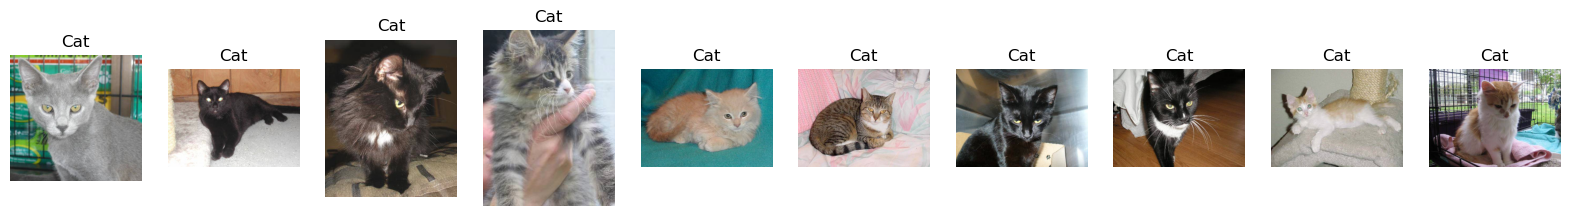

In [7]:
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread


test_data_dir = 'dataset/test_data_small/cat'


cat_images = os.listdir(test_data_dir)


plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.4)

for i in range(10):
    plt.subplot(1, 10, i + 1)
    
   
    filename = os.path.join(test_data_dir, cat_images[i])
    image = imread(filename)
    

    plt.imshow(image)
    plt.title('Cat', fontsize=12)
    plt.axis('off')  


plt.show()


### Data Preprocessing

In [4]:



img_height, img_width = 128, 128
batch_size = 64
seed = 42

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect',
    validation_split=0.2  
)


test_datagen = ImageDataGenerator(rescale=1.0/255)


train_generator = train_datagen.flow_from_directory(
    directory='dataset/train_data_small', 
    target_size=(img_height, img_width),
    class_mode='binary',
    subset='training',
    shuffle=True,
    batch_size = batch_size,
    seed=seed
)

val_generator = train_datagen.flow_from_directory(
    directory='dataset/train_data_small',  
    target_size=(img_height, img_width),
    class_mode='binary',
    subset='validation', 
    shuffle=False,
    batch_size = batch_size,
    seed=seed
)

test_generator = test_datagen.flow_from_directory(
    directory='dataset/test_data_small', 
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size = batch_size,
    shuffle=False,
    seed=seed
)

# Print the number of samples in each generator
print(f"Number of training samples: {train_generator.samples}")
print(f"Number of validation samples: {val_generator.samples}")
print(f"Number of testing samples: {test_generator.samples}")


Found 1602 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Number of training samples: 1602
Number of validation samples: 400
Number of testing samples: 400


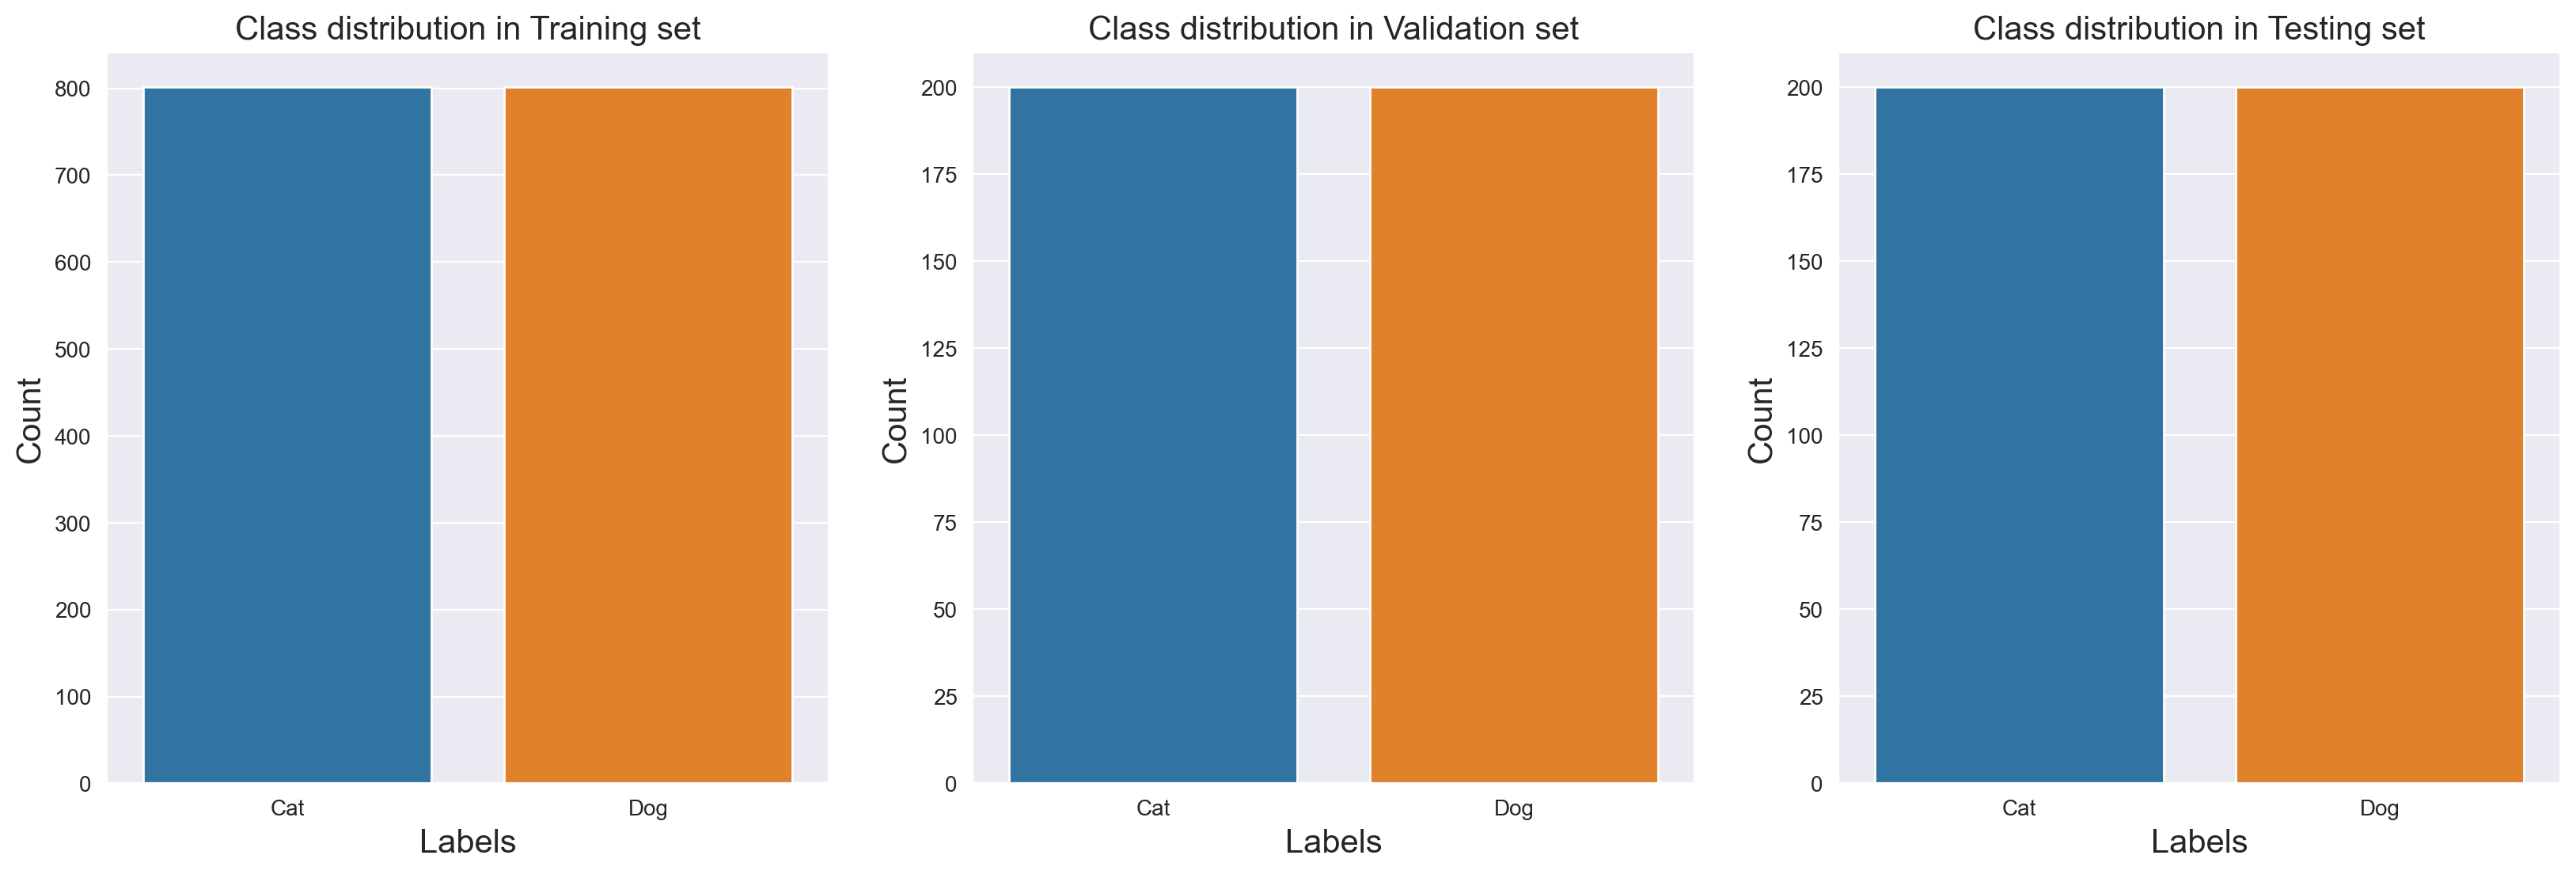

In [9]:

train_counts = np.bincount(train_generator.classes)
val_counts = np.bincount(val_generator.classes)
test_counts = np.bincount(test_generator.classes)


labels = ['Cat', 'Dog']


uni1 = pd.DataFrame(data=train_counts, index=labels, columns=['Count1'])
uni2 = pd.DataFrame(data=val_counts, index=labels, columns=['Count2'])
uni3 = pd.DataFrame(data=test_counts, index=labels, columns=['Count3'])


plt.figure(figsize=(20, 6), dpi=200)
sns.set_style('darkgrid')


plt.subplot(131)
sns.barplot(data=uni1, x=uni1.index, y='Count1', hue=uni1.index, legend=False).set_title('Class distribution in Training set', fontsize=15)
plt.xlabel('Labels', fontsize=15)
plt.ylabel('Count', fontsize=15)


plt.subplot(132)
sns.barplot(data=uni2, x=uni2.index, y='Count2', hue=uni2.index, legend=False).set_title('Class distribution in Validation set', fontsize=15)
plt.xlabel('Labels', fontsize=15)
plt.ylabel('Count', fontsize=15)


plt.subplot(133)
sns.barplot(data=uni3, x=uni3.index, y='Count3', hue=uni3.index, legend=False).set_title('Class distribution in Testing set', fontsize=15)
plt.xlabel('Labels', fontsize=15)
plt.ylabel('Count', fontsize=15)

plt.show()



#### Simple Convolutional Neural Network

In [11]:
from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(
    include_top=False,    
    weights='imagenet',   
    input_shape=(128, 128, 3)  
)


base_model.trainable = False


model = Sequential([
    base_model,                           
    GlobalAveragePooling2D(),             
    Dense(512, activation='relu'),   
    Dropout(0.5),                          # Dropout layer to prevent overfitting (50% dropout)
    Dense(1, activation='sigmoid')         
])
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,914,369 (11.12 MB)

 Trainable params: 656,385 (2.50 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 932ms/step - accuracy: 0.5323 - loss: 1.6435
Epoch 1: val_loss improved from inf to 0.69385, saving model to customsimple.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5336 - loss: 1.6219 - val_accuracy: 0.5000 - val_loss: 0.6939 - learning_rate: 0.0010
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 916ms/step - accuracy: 0.6356 - loss: 0.6476
Epoch 2: val_loss improved from 0.69385 to 0.69363, saving model to customsimple.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6358 - loss: 0.6473 - val_accuracy: 0.5000 - val_loss: 0.6936 - learning_rate: 0.0010
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 887ms/step - accuracy: 0.6739 - loss: 0.6102
Epoch 3: val_loss did not improve from 0.69363
26/26 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6740 - loss: 0.6104 - val_accuracy: 0.5000 - val_loss: 0.7423 - learning_rate: 0.0010
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 977ms/step - accuracy: 0.7004 - loss: 0.5972
Epoch 4: val_loss 

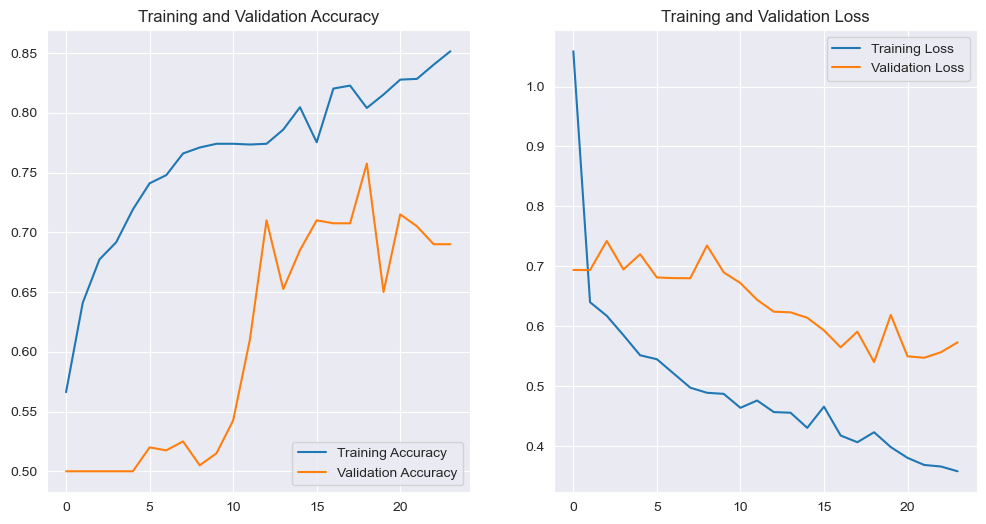

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 337ms/step - accuracy: 0.7667 - loss: 0.5241
Test accuracy: 0.76
Test loss: 0.52
Final Training Accuracy: 0.85, Loss: 0.36
Final Validation Accuracy: 0.69, Loss: 0.57


In [11]:

#img parameters
img_height, img_width = 128, 128
batch_size = 64
seed = 42
image_channel = 3

#architecture
model = Sequential()


model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, image_channel)))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))


model.add(Flatten())
model.add(Dense(512, activation='relu'))

# the output layer for a binary classifier - sigmoid because 0s and 1s
model.add(Dense(1, activation='sigmoid'))

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.0001
)

checkpoint = ModelCheckpoint(
    filepath='customsimple.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)


def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')


    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


plot_history(history)


test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test accuracy: {test_acc:.2f}')
print(f'Test loss: {test_loss:.2f}')


train_acc = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy: {train_acc:.2f}, Loss: {train_loss:.2f}")
print(f"Final Validation Accuracy: {val_acc:.2f}, Loss: {val_loss:.2f}")



#### Complicated Convolutional Neural Network

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 942ms/step - accuracy: 0.5593 - loss: 0.9425
Epoch 1: val_loss improved from inf to 0.69203, saving model to customcomplicated.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5602 - loss: 0.9369 - val_accuracy: 0.6125 - val_loss: 0.6920 - learning_rate: 0.0010
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - accuracy: 0.6407 - loss: 0.6610
Epoch 2: val_loss improved from 0.69203 to 0.69044, saving model to customcomplicated.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 996ms/step - accuracy: 0.6402 - loss: 0.6611 - val_accuracy: 0.5875 - val_loss: 0.6904 - learning_rate: 0.0010
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - accuracy: 0.6298 - loss: 0.6315
Epoch 3: val_loss improved from 0.69044 to 0.68847, saving model to customcomplicated.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6312 - loss: 0.6309 - val_accuracy: 0.5625 - val_loss: 0.6885 - learning_rate: 0.0010
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 880ms

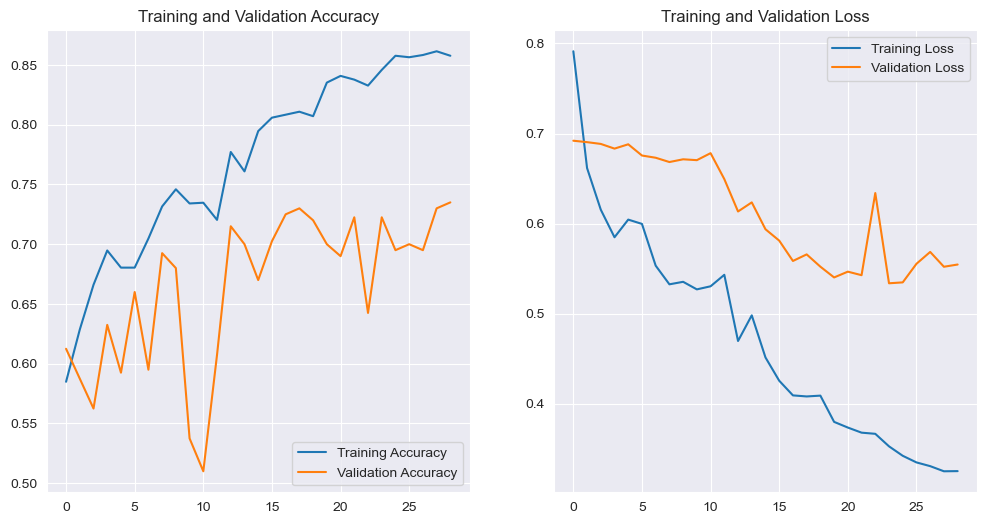

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step - accuracy: 0.6888 - loss: 0.5870
Test accuracy: 0.72
Test loss: 0.53
Final Training Accuracy: 0.86, Loss: 0.33
Final Validation Accuracy: 0.74, Loss: 0.55


In [12]:


# Define image parameters and augmentation setup
img_height, img_width = 128, 128
batch_size = 64
seed = 42
image_channel = 3

model = Sequential()

# Input Layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))


# Block 1
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


# Block 2
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Fully Connected layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))

# Output layer (binary classification)
model.add(Dense(1, activation='sigmoid'))

# Batch size and steps calculation
steps_per_epoch = 1602 //64
validation_steps = 400//64


# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.0001
)

checkpoint = ModelCheckpoint(
    filepath='customcomplicated.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)



history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)


def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)


test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test accuracy: {test_acc:.2f}')
print(f'Test loss: {test_loss:.2f}')

# Print final training and validation metrics
train_acc = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy: {train_acc:.2f}, Loss: {train_loss:.2f}")
print(f"Final Validation Accuracy: {val_acc:.2f}, Loss: {val_loss:.2f}")



#### Custom Convolutional Neural Network

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,914,369 (11.12 MB)

 Trainable params: 656,385 (2.50 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.6572 - loss: 0.6303
Epoch 1: val_loss improved from inf to 0.23543, saving model to mobilenetv2_finetuned.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 658ms/step - accuracy: 0.6606 - loss: 0.6253 - val_accuracy: 0.9200 - val_loss: 0.2354 - learning_rate: 0.0100
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.8890 - loss: 0.2772
Epoch 2: val_loss improved from 0.23543 to 0.17641, saving model to mobilenetv2_finetuned.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 550ms/step - accuracy: 0.8893 - loss: 0.2765 - val_accuracy: 0.9400 - val_loss: 0.1764 - learning_rate: 0.0100
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9064 - loss: 0.2323
Epoch 3: val_loss improved from 0.17641 to 0.15997, saving model to mobilenetv2_finetuned.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 522ms/step - accuracy: 0.9065 - loss: 0.2323 - val_accuracy: 0.9275 - val_loss: 0.1600 - learning_rate: 0.0100
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━

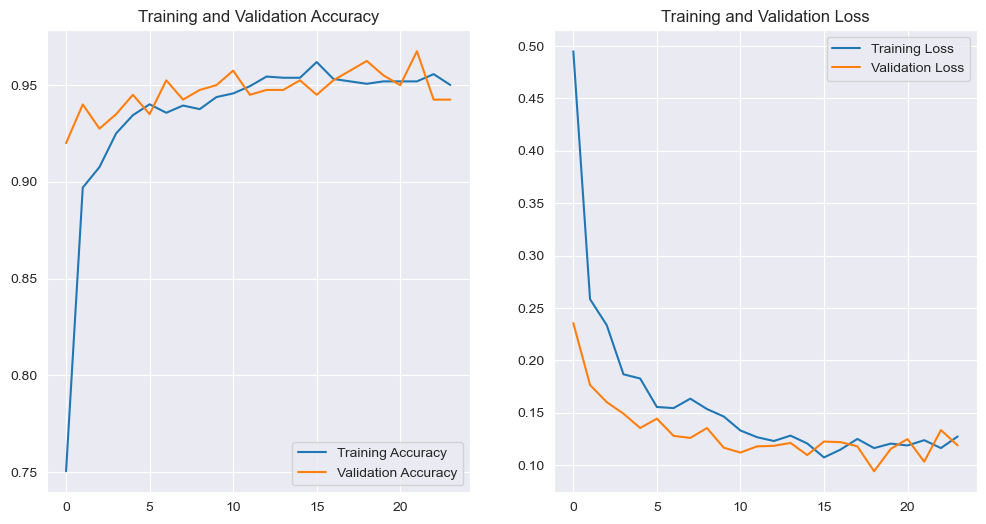

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 293ms/step - accuracy: 0.9624 - loss: 0.1055
Test accuracy: 0.97
Test loss: 0.10
Final Training Accuracy: 0.95, Loss: 0.13
Final Validation Accuracy: 0.94, Loss: 0.12


In [23]:
from tensorflow.keras.applications import MobileNetV2

# We load for our final test a pretrained CNN model
base_model = MobileNetV2(
    include_top=False,    
    weights='imagenet',   
    input_shape=(128, 128, 3)  
)


base_model.trainable = False


model = Sequential([
    base_model,                           
    GlobalAveragePooling2D(),             
    Dense(512, activation='relu'),   
    Dropout(0.5),                          # Dropout layer to prevent overfitting (50% dropout)
    Dense(1, activation='sigmoid')         
])


model.compile(
    optimizer='sgd',                      # SGD optimizer
    loss='binary_crossentropy',            
    metrics=['accuracy']                   
)

# Define the callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',                    
    patience=5,                            
    restore_best_weights=True              
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',                    
    factor=0.2,                           
    patience=3,                          
    min_lr=0.0001                         
)

checkpoint = ModelCheckpoint(
    filepath='mobilenetv2_finetuned.keras', 
    save_best_only=True,                  
    monitor='val_loss',                    
    verbose=1                             
)

model.summary()

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    verbose=1,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)


def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)


test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test accuracy: {test_acc:.2f}')
print(f'Test loss: {test_loss:.2f}')

# Print final training and validation metrics
train_acc = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy: {train_acc:.2f}, Loss: {train_loss:.2f}")
print(f"Final Validation Accuracy: {val_acc:.2f}, Loss: {val_loss:.2f}")



#### SVM method

Processing training data...


100%|██████████| 26/26 [00:08<00:00,  2.98it/s]


Scaling features...
Training SVM...


/opt/anaconda3/envs/AIMA/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Processing validation data...


100%|██████████| 7/7 [00:01<00:00,  3.59it/s]


Processing test data...


100%|██████████| 7/7 [00:00<00:00,  8.16it/s]


Calibrating model...

Validation Results:
Accuracy: 0.5750

Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.57      0.62      0.59       200
         1.0       0.58      0.53      0.55       200

    accuracy                           0.57       400
   macro avg       0.58      0.57      0.57       400
weighted avg       0.58      0.57      0.57       400


Test Results:
Accuracy: 0.5400

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.54      0.59      0.56       200
         1.0       0.54      0.48      0.51       200

    accuracy                           0.54       400
   macro avg       0.54      0.54      0.54       400
weighted avg       0.54      0.54      0.54       400



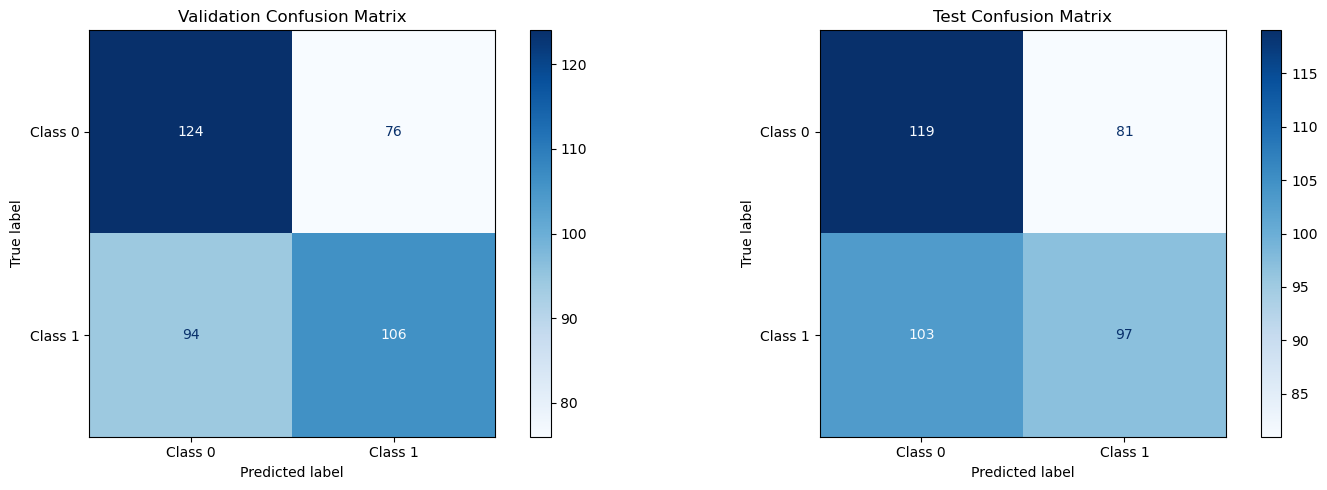

Validation Accuracy: 0.5750
Test Accuracy: 0.5400


In [5]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def train_image_svm(train_generator, val_generator, test_generator, max_iter=1000):
    """
    Train SVM classifier using image data from Keras generators.
    Optimized for 128x128 images with binary classification.
    """
  
    n_features = 128 * 128 * 3  # height * width * channels
    
    print("Processing training data...")

    n_train = train_generator.samples
    X_train = np.zeros((n_train, n_features))
    y_train = np.zeros(n_train)
    
  
    train_generator.reset()
    for i in tqdm(range(len(train_generator))):
        batch_x, batch_y = next(train_generator)
        start_idx = i * train_generator.batch_size
        end_idx = min((i + 1) * train_generator.batch_size, n_train)
        X_train[start_idx:end_idx] = batch_x.reshape(-1, n_features)
        y_train[start_idx:end_idx] = batch_y
    
    # Scale the features
    print("Scaling features...")
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    
    # Train SVM
    print("Training SVM...")
    svm = LinearSVC(
        max_iter=max_iter,
        dual='auto',
        random_state=42,
       
    )
    svm.fit(X_train, y_train)
    
    # Process validation data
    print("Processing validation data...")
    n_val = val_generator.samples
    X_val = np.zeros((n_val, n_features))
    y_val = np.zeros(n_val)
    
    val_generator.reset()
    for i in tqdm(range(len(val_generator))):
        batch_x, batch_y = next(val_generator)
        start_idx = i * val_generator.batch_size
        end_idx = min((i + 1) * val_generator.batch_size, n_val)
        X_val[start_idx:end_idx] = batch_x.reshape(-1, n_features)
        y_val[start_idx:end_idx] = batch_y
    
    X_val = scaler.transform(X_val)
    
    # Process test data
    print("Processing test data...")
    n_test = test_generator.samples
    X_test = np.zeros((n_test, n_features))
    y_test = np.zeros(n_test)
    
    test_generator.reset()
    for i in tqdm(range(len(test_generator))):
        batch_x, batch_y = next(test_generator)
        start_idx = i * test_generator.batch_size
        end_idx = min((i + 1) * test_generator.batch_size, n_test)
        X_test[start_idx:end_idx] = batch_x.reshape(-1, n_features)
        y_test[start_idx:end_idx] = batch_y
    
    X_test = scaler.transform(X_test)
    
    # Calibrate model for probability scores
    print("Calibrating model...")
    calibrated_svm = CalibratedClassifierCV(svm, cv='prefit')
    calibrated_svm.fit(X_val, y_val)
    
 
    val_pred = svm.predict(X_val)
    test_pred = svm.predict(X_test)
    

    val_proba = calibrated_svm.predict_proba(X_val)
    test_proba = calibrated_svm.predict_proba(X_test)
    

    val_accuracy = accuracy_score(y_val, val_pred)
    test_accuracy = accuracy_score(y_test, test_pred)
    
  
    val_cm = confusion_matrix(y_val, val_pred)
    test_cm = confusion_matrix(y_test, test_pred)
    
    # Print results
    print("\nValidation Results:")
    print(f"Accuracy: {val_accuracy:.4f}")
    print("\nValidation Classification Report:")
    print(classification_report(y_val, val_pred))
    
    print("\nTest Results:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print("\nTest Classification Report:")
    print(classification_report(y_test, test_pred))
    
    # Plot confusion matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=['Class 0', 'Class 1']).plot(ax=ax1, cmap='Blues')
    ax1.set_title('Validation Confusion Matrix')
    
    ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=['Class 0', 'Class 1']).plot(ax=ax2, cmap='Blues')
    ax2.set_title('Test Confusion Matrix')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'model': svm,
        'calibrated_model': calibrated_svm,
        'scaler': scaler,
        'val_accuracy': val_accuracy,
        'test_accuracy': test_accuracy,
        'val_confusion_matrix': val_cm,
        'test_confusion_matrix': test_cm,
        'val_predictions': val_pred,
        'test_predictions': test_pred,
        'val_probabilities': val_proba,
        'test_probabilities': test_proba
    }


# Train the SVM
results = train_image_svm(train_generator, val_generator, test_generator)

# Access the trained model and results
svm_model = results['model']
calibrated_model = results['calibrated_model']
scaler = results['scaler']


print(f"Validation Accuracy: {results['val_accuracy']:.4f}")
print(f"Test Accuracy: {results['test_accuracy']:.4f}")


#### CLIP Open AI Zero-shot Classifier 


100%|██████████| 7/7 [01:04<00:00,  9.19s/it]


Accuracy: 0.9975
              precision    recall  f1-score   support

         cat       1.00      0.99      1.00       200
         dog       1.00      1.00      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



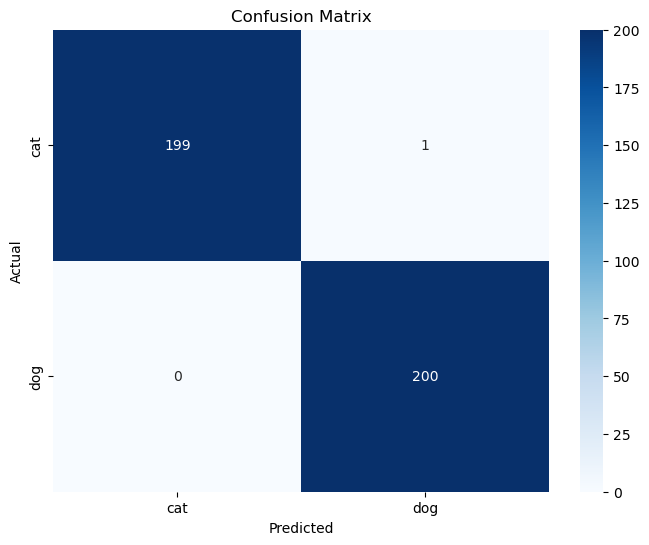

In [12]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
class_names = ["cat", "dog"] 

def zero_shot_classify(image, class_names):
    inputs = processor(
        text=class_names,
        images=image,
        return_tensors="pt",
        padding=True
    )
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1)
    
    return probs[0].numpy()

predictions = []
true_labels = []

for i in tqdm(range(len(test_generator))):
    batch_images, batch_labels = test_generator[i]
    
    for image, label in zip(batch_images, batch_labels):
        pil_image = Image.fromarray((image * 255).astype(np.uint8))
        probs = zero_shot_classify(pil_image, class_names)
        predicted_class = np.argmax(probs)
        
        predictions.append(predicted_class)
        true_labels.append(int(label))

predictions = np.array(predictions)
true_labels = np.array(true_labels)


accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(true_labels, predictions, target_names=class_names))


cm = confusion_matrix(true_labels, predictions)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
